# Extracting data from Dopplers
This Jupyter notebook extracts useful information from spectrogram images of Doppler shifts recorded on seismometers, e.g. Raspberry Shakes. 

The script generates a spectrogram from the seismometer data. The code makes a first guess at the curve to fit the Doppler shift. 

The user moves slider controls to adjust the values of the parameters that control the shape and position of the curve in relation to the Doppler shift in the spectrogram. When the user is satisfied the fit is good enough, the script can save the best fit curve with the underlying spectrogram image. And the script prints out the best fit parameters.

First, the libraries we need:

In [56]:
%matplotlib notebook 

import ipywidgets as widgets
import numpy as np 
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

Now let's download a time slice of seismometer data, and calculate the spectrogram:

<IPython.core.display.Javascript object>


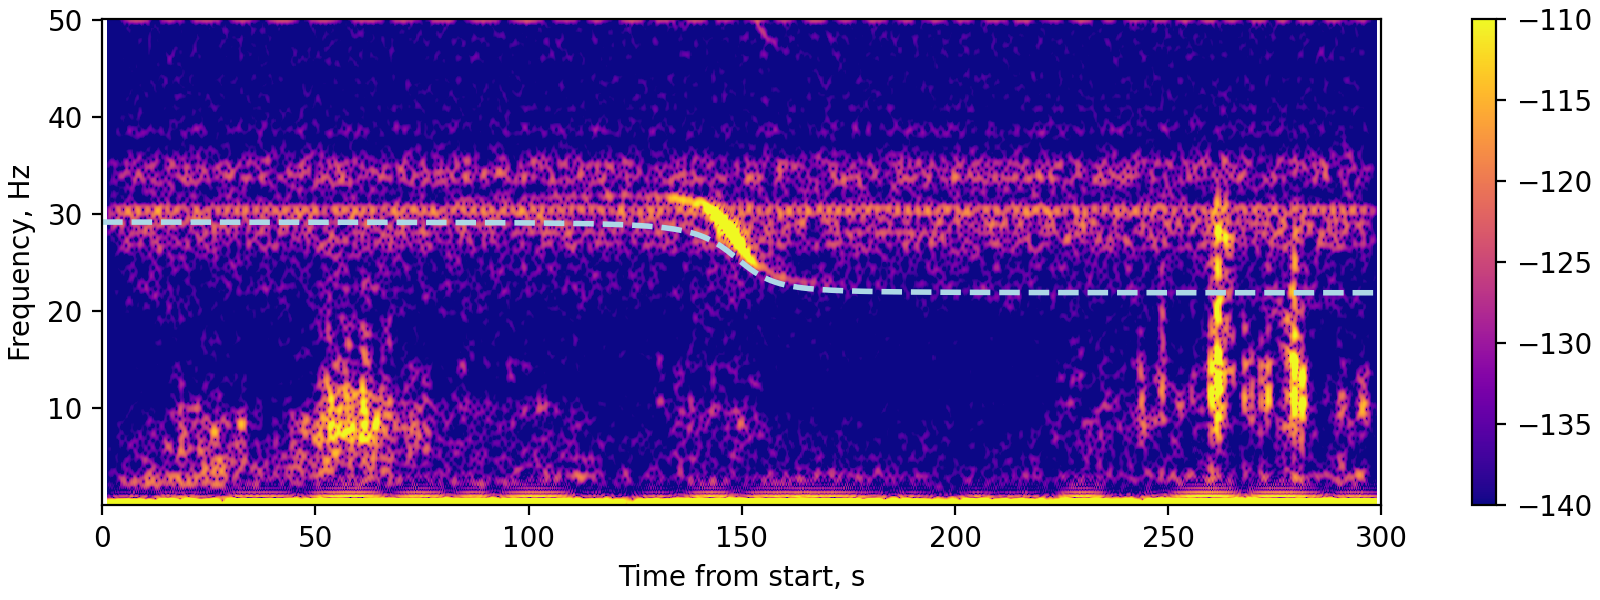

interactive(children=(IntSlider(value=100, description='Vel of source (m/s)', max=200, step=2, style=SliderSty…

In [57]:
T_START = 0     # length in seconds of data to plot before origin time
T_END = 60*5    # length in seconds of data to plot after origin time

#   now get some station meta data, esp. lat & long 
namStation1 = 'R3FEA'    #   Oswald Road, Chorlton UK
netStation1 = 'AM'
locStation1 = '00'
chaStation1 = 'EHZ'      #   vertical component of geophone 
client1 = Client('RASPISHAKE')
metadata1 = client1.get_stations(network=netStation1, station=namStation1, location=locStation1, channel=chaStation1, level='resp')
idSEED1 = netStation1 + '.' + namStation1 + '.' + locStation1 + '.' + chaStation1 
latStation1 = metadata1[0].get_coordinates(idSEED1, UTCDateTime())['latitude']
lonStation1 = metadata1[0].get_coordinates(idSEED1, UTCDateTime())['longitude']
eleStation1 = metadata1[0].get_coordinates(idSEED1, UTCDateTime())['elevation']

#   start of 'event' 
#dtEvent1 = UTCDateTime("2021-12-08T04:17:00")
dtEvent1 = UTCDateTime("2021-12-08T04:30:00")

#   get the data
#   plot seismograms  
t1 = dtEvent1 - T_START
t2 = dtEvent1 + T_END

# Download and filter data for station1
st1 = client1.get_waveforms(netStation1, namStation1, locStation1, chaStation1,
                          starttime=t1, endtime=t2, attach_response=True)
st1.merge(method=0, fill_value='latest')
st1.detrend(type="demean")
st1.remove_response()
st1.trim(t1, t2)

# Now plot the spectrogram from these data
fig = plt.figure(figsize=(8,3), constrained_layout=True)
axs = fig.gca()
st1[0].spectrogram(log=False, wlen=3, axes=axs, dbscale=True, 
                   cmap='plasma', show=True, samp_rate=st1[0].stats.sampling_rate)
mappable = axs.images[0]
xlim = axs.get_xlim()
ylim = axs.get_ylim()
axs.set_ylabel('Frequency, Hz')
axs.set_xlabel('Time from start, s')
# You might need to adjust these limits for your data... 
for im in fig.gca().get_images():
    im.set_clim(-140,-110)
plt.colorbar(mappable=mappable, ax=axs)
plt.show()

# an array of times, with 0 at the centre, and -ve before and +ve after 
t = np.arange(-xlim[1]/2, xlim[1]/2, 1.)

# and now the interactive widgets to constrain the 'best fit' frequency as a function of time for the Doppler
style = {'description_width': 'initial'}
@widgets.interact(vSource=widgets.IntSlider(min=0, max=200, step=2, value=100, description="Vel of source (m/s)", style=style), 
                  dSource=widgets.IntSlider(min=0, max=5000, step=100, value=1000, description="Dist of source (m)", style=style), 
                  vSubstrate=widgets.IntSlider(min=0, max=6000, step=50, value=700, description="Vel of medium (m/s)", style=style), 
                  tOffset=widgets.IntSlider(min=xlim[0], max=xlim[1], step=1, value=round(xlim[1]/2), description="Offset time (s)", style=style), 
                  f0=widgets.IntSlider(min=ylim[0], max=ylim[1], step=1, value=round(ylim[1]/2), description="Central freq. (Hz)", style=style))
def plotUpdate(vSource, dSource, vSubstrate, tOffset, f0):
    [l.remove() for l in axs.lines]
    # equation from Lubyako et al., 2017 Physics Education 
    f = (vSubstrate * f0) / (vSubstrate + vSource * np.sin(np.arctan(vSource * t / dSource))) 
    axs.plot(t+tOffset, f, '--', color='lightblue', linewidth=2)
    plt.show()